In [73]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

In [74]:
# Training data is 10^2 points in [-2,2] inclusive regularly spaced
Theta1 = np.linspace(-2,2,10) #1x10
Theta2 = np.linspace(-2,2,10) #1x10
train_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform Arrays 10x10 (.T turns this into 10 10x2 arrays) (Why?)
x = torch.tensor(np.linspace(-2,2,5)) #1x5

#Gives every combination of 
train_T = torch.tensor(train_mesh.T.reshape(-1, 2))#100x2

noise_mean = 0
noise_std = 0.1**2
Theta_True = torch.tensor([1,-1]) #1x2

#Creates noise values with a certain stdev and mean from a normal distribution
noise = torch.tensor(np.random.normal(size=len(x),loc = noise_mean, scale = noise_std)) #1x5

# True function is y=T1*x + T2*x^2 + x^3 with Gaussian noise
y_true =  Theta_True[0]*x + Theta_True[1]*x**2 +x**3 + noise #1x5

train_y = torch.tensor(np.zeros(len(train_T))) #1 x 100

#Iterates over evey combination of theta to find the SSE for each combination
for i in range(len(train_T)):
    theta_1 = train_T[i,0] #100x1 
    theta_2 = train_T[i,1] #100x1
    y_exp = theta_1*x + theta_2*x**2 +x**3 + noise #100 x5
    train_y[i] = sum((y_true - y_exp)**2) # A number

In [97]:
# We will use the simplest form of GP model, exact inference
#This class is the Exact GP model
class ExactGPModel(gpytorch.models.ExactGP): #Exact GP does not add noise
    r"""
    The base class for any Gaussian process latent function to be used in conjunction
    with exact inference.

    :param torch.Tensor train_inputs: (size n x d) The training features :math:`\mathbf X`.
    :param torch.Tensor train_targets: (size n) The training targets :math:`\mathbf y`.
    :param ~gpytorch.likelihoods.GaussianLikelihood likelihood: The Gaussian likelihood that defines
        the observational distribution. Since we're using exact inference, the likelihood must be Gaussian.

    The :meth:`forward` function should describe how to compute the prior latent distribution
    on a given input. Typically, this will involve a mean and kernel function.
    The result must be a :obj:`~gpytorch.distributions.MultivariateNormal`.

    Calling this model will return the posterior of the latent Gaussian process when conditioned
    on the training data. The output will be a :obj:`~gpytorch.distributions.MultivariateNormal`."""

    def __init__(self, train_T, train_y, likelihood):
        #Initializes the GP model with train_Y, train_y, and the likelihood
        ##What is super and what does it do?
        super(ExactGPModel, self).__init__(train_T, train_y, likelihood)
        #Sets a constant mean on the model
        self.mean_module = gpytorch.means.ConstantMean()
        #Sets covariance matrix to a scaled RFB Kernel
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
        print(self.covar_module)
    #What is x here?
    def forward(self, x):
        """
        Args: 
        self: A class. The model itself. In this case, gpytorch.models.ExactGP
        x: train_T
        """
        mean_x = self.mean_module(x) #1x100
        covar_x = self.covar_module(x) #1x100
         print(covar_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_T, train_y, likelihood)

IndentationError: unexpected indent (Temp/ipykernel_5436/3524091515.py, line 38)

In [98]:
# Find optimal model hyperparameters
training_iter = 3

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters 
#Should I change lr? How do I know what would be best? Research this

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_T)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#          model.likelihood.noise.item()
#     ))
    optimizer.step()

tensor([0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975, 0.2975,
        0.2975], grad_fn=<ExpandBackward0>)
tensor([0.3975, 0.3975, 0.3975, 0.3975, 0.3975, 0.3975, 0.3975, 0.3975, 0.39

In [78]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

#Define Testing Data
test_Theta1 =  np.linspace(-2,2,5) #1x5
test_Theta2 =  np.linspace(-2,2,5) #1x5
test_mesh = np.array(np.meshgrid(test_Theta1, test_Theta2)) #2 Uniform 5x5 arrays

In [79]:
def sse_func(mesh):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        mesh: Uniform array of all x values for each theta
    Returns:
        sse: x by x sum of squared error matrix of all combinations of the mesh
    '''
   
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_T = torch.tensor(mesh.T.reshape(-1, 2))
        observed_pred = likelihood(model(test_T))
    sse = observed_pred.loc.reshape(len(test_Theta1),-1)
    
    return sse #Must traspose zz. Why?

tensor([11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043, 11.9043,
        11.9043, 11.9043, 11.9043, 11.90

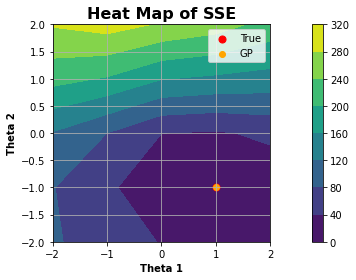

In [80]:
# plot fheatmap
xx , yy = test_mesh #2 Uniform 5x5 arrays
test_T = torch.tensor(test_mesh.T.reshape(-1, 2)) #25 x 2

zz = sse_func(test_mesh) #5 x 5
Theta_GP = test_T[np.argmin(zz)].numpy() #1x2
print("The GP predicts that Theta1 =",Theta_GP[0],"and Theta2 =", Theta_GP[1])

plt.contourf(xx,yy,zz.T)
plt.colorbar()
plt.scatter(Theta_True[0],Theta_True[1], color="red", label = "True", s=50)
plt.scatter(Theta_GP[0],Theta_GP[1], color="orange", label = "GP")
plt.axis('scaled')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Theta 1',weight='bold')
plt.ylabel('Theta 2',weight='bold')
plt.title('Heat Map of SSE', weight='bold',fontsize = 16)
plt.show()